In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [221]:
stations_df = pd.read_pickle('../../Dataset/MyMethod/DailyStations_Interpolated.pkl')
stations_df.head()

,Station_Name,Transactions
0,BOULDER / JUNCTION ST1,Energy__kWh_ Year Month W...
1,BOULDER / ALPINE ST1,Energy__kWh_ Year Month ...
2,BOULDER / BASELINE ST1,Energy__kWh_ Year Month ...
3,BOULDER / FACILITIES ST1,Energy__kWh_ Year Month ...
4,COMM VITALITY / 1500PEARL2,Energy__kWh_ Year Month W...


In [222]:
stations_df.loc[1,'Transactions'].columns

Index(['Energy__kWh_', 'Year', 'Month', 'Weekday', 'Maximum T', 'Minimum T',
       'Precipitation', 'Snow', 'Charging_Time_min',
       'Remaining_Park_After_Charge_(min)'],
      dtype='object')

In [223]:
stations_df['Transactions'].apply(lambda row: row.drop(columns={'Year','Charging_Time_min', 'Remaining_Park_After_Charge_(min)'}, inplace=True))
stations_df.loc[1,'Transactions'].columns

Index(['Energy__kWh_', 'Month', 'Weekday', 'Maximum T', 'Minimum T',
       'Precipitation', 'Snow'],
      dtype='object')

In [224]:
stations_df.loc[1,'Transactions'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2157 entries, 2018-01-03 to 2023-11-29
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Energy__kWh_   2157 non-null   float64
 1   Month          2157 non-null   object 
 2   Weekday        2157 non-null   object 
 3   Maximum T      2157 non-null   float64
 4   Minimum T      2157 non-null   float64
 5   Precipitation  2157 non-null   float64
 6   Snow           2157 non-null   float64
dtypes: float64(5), object(2)
memory usage: 134.8+ KB


In [225]:
def preprocess_data(row, categorical_columns, numerical_columns):

    # One-hot encoding for categorical columns
    all_dummy_columns = set()  # To store all unique dummy columns

    # One-hot encoding for categorical columns
    for col in categorical_columns:
        row["Transactions"] = pd.get_dummies(row["Transactions"], columns=[col], prefix=col)
        all_dummy_columns.update(row["Transactions"].columns)
    
    # MinMax scaling for numerical columns
    scaler = MinMaxScaler()
    row["Transactions"][numerical_columns] = scaler.fit_transform(row["Transactions"][numerical_columns])

    return row, all_dummy_columns, scaler


categorical_columns = ['Weekday', 'Month']
numerical_columns = ['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation']

result = stations_df.apply(lambda row: preprocess_data(row, categorical_columns, numerical_columns), axis=1)

# Unpack the result into two variables
stations_df_scaled = result.apply(lambda x: x[0])
all_dummy_columns = result.apply(lambda x: x[1]).iloc[0]
scaler = result.apply(lambda x: x[2])

In [193]:
# Items to remove
items_to_remove = ['Weekday','Month', 'Snow', 'Energy__kWh_', 'Maximum T', 'Minimum T']

for item in items_to_remove:
    all_dummy_columns.discard(item)

all_dummy_columns

{'Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Precipitation',
 'Weekday_Friday',
 'Weekday_Monday',
 'Weekday_Saturday',
 'Weekday_Sunday',
 'Weekday_Thursday',
 'Weekday_Tuesday',
 'Weekday_Wednesday'}

In [194]:
stations_df_scaled.loc[0,'Transactions'].shape

(163, 18)

In [195]:
for group_df in stations_df_scaled['Transactions']:
    for dummy_col in all_dummy_columns:
        if dummy_col not in group_df.columns:
            group_df[dummy_col] = 0

In [196]:
stations_df_scaled.loc[0,'Transactions'].shape

(163, 24)

In [197]:
stations_df_scaled.loc[0,'Transactions'].columns

Index(['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow',
       'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
       'Weekday_Wednesday', 'Month_August', 'Month_July', 'Month_June',
       'Month_November', 'Month_October', 'Month_September', 'Month_April',
       'Month_January', 'Month_May', 'Month_March', 'Month_February',
       'Month_December'],
      dtype='object')

In [198]:
stations_df_scaled.loc[0,'Transactions'].head()

,Energy__kWh_,Maximum T,Minimum T,Precipitation,Snow,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Month_August,Month_July,Month_June,Month_November,Month_October,Month_September,Month_April,Month_January,Month_May,Month_March,Month_February,Month_December
2023-06-21,0.286377,0.291317,0.276371,0.264151,0.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2023-06-22,0.574469,0.278711,0.289030,1.000000,0.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2023-06-23,0.496137,0.378151,0.417722,0.075472,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2023-06-24,0.441072,0.417367,0.417722,0.000000,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2023-06-25,0.206956,0.173669,0.156118,0.000000,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [199]:
# Split the dataset into training, validation, and testing sets
def split_dataset(df, train_ratio, val_ratio):

    total_size = len(df)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_df = df[:train_size]
    val_df = df[train_size:train_size + val_size]
    test_df = df[train_size + val_size:]

    assert len(train_df) + len(val_df) + len(test_df) == total_size, "Dataset not split correctly."

    print(f'Training split ratio:   {round(len(train_df) / len(df), 3)}')
    print(f'Validation split ratio: {round(len(val_df) / len(df), 3)}')
    print(f'Testing split ratio:    {round(len(test_df) / len(df), 3)}')
    print("\nShapes of the datasets:")
    print(train_df.shape, val_df.shape, test_df.shape)

    return train_df, val_df, test_df

train_daily_scaled, val_daily_scaled, test_daily_scaled = split_dataset(stations_df_scaled, train_ratio=0.7, val_ratio=0.2)

Training split ratio:   0.692
Validation split ratio: 0.179
Testing split ratio:    0.128

Shapes of the datasets:
(27, 2) (7, 2) (5, 2)


In [200]:
train_daily_scaled.loc[0,'Transactions'].head()

,Energy__kWh_,Maximum T,Minimum T,Precipitation,Snow,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Month_August,Month_July,Month_June,Month_November,Month_October,Month_September,Month_April,Month_January,Month_May,Month_March,Month_February,Month_December
2023-06-21,0.286377,0.291317,0.276371,0.264151,0.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2023-06-22,0.574469,0.278711,0.289030,1.000000,0.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2023-06-23,0.496137,0.378151,0.417722,0.075472,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2023-06-24,0.441072,0.417367,0.417722,0.000000,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2023-06-25,0.206956,0.173669,0.156118,0.000000,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [201]:
def generate_sequences_targets(data, features, target_columns, sequence_length):
    inputs = []
    targets = []

    for group_df in data:
        group_df = group_df[features]

        for t in range(0, len(group_df) - sequence_length):
            sequence = group_df.iloc[t:t + sequence_length].values
            target = group_df.iloc[t + sequence_length][target_columns].values

            inputs.append(sequence)
            targets.append(target)
    
    inputs_array = np.array(inputs)
    targets_array = np.array(targets)

    print(f'Dataset split into sequences:')
    print(f'Sequences shape: {inputs_array.shape}')
    print(f'Targets shape: {targets_array.shape}\n')

    return inputs_array, targets_array

In [202]:
# Assuming stations_test is your DataFrame
features = train_daily_scaled.loc[0,'Transactions'].columns.to_list()
target_columns = ['Energy__kWh_']
sequence_length = 24

train_data_inputs, train_data_targets = generate_sequences_targets(train_daily_scaled['Transactions'], features, target_columns, sequence_length)
val_data_inputs, val_data_targets = generate_sequences_targets(val_daily_scaled['Transactions'], features, target_columns, sequence_length)
test_data_inputs, test_data_targets = generate_sequences_targets(test_daily_scaled['Transactions'], features, target_columns, sequence_length)

Dataset split into sequences:
Sequences shape: (3753, 24, 24)
Targets shape: (3753, 1)

Dataset split into sequences:
Sequences shape: (973, 24, 24)
Targets shape: (973, 1)

Dataset split into sequences:
Sequences shape: (695, 24, 24)
Targets shape: (695, 1)



In [203]:
num_features = len(features)

# The input Datasets must have this input shape (-1, sequence_length, num_features)
train_data_inputs = train_data_inputs.reshape((-1, sequence_length, num_features))
val_data_inputs = val_data_inputs.reshape((-1, sequence_length, num_features))
test_data_inputs = test_data_inputs.reshape((-1, sequence_length, num_features))

train_data_inputs.shape, val_data_inputs.shape, test_data_inputs.shape

((3753, 24, 24), (973, 24, 24), (695, 24, 24))

In [204]:
%run "../Transformer_Paper/Transformer.ipynb"

# Define the hyperparameters of the manual model
input_shape = (sequence_length, num_features)
num_heads = 1
d_ff = 64
num_layers = 6
dropout_rate = 0.1
encoder_mask = None
decoder_mask = tf.linalg.band_part(tf.ones((sequence_length, sequence_length)), -1, 0)  # Create a lower triangular mask
decoder_mask = 1 - decoder_mask  # Invert the mask

# Create the transformer model
manul_model = TransformerModel(input_shape, num_heads, d_ff, num_layers, dropout_rate, encoder_mask, decoder_mask)

manul_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 24, 24)]     0           []                               
                                                                                                  
 multi_head_attention_95 (Multi  (None, None, 24)    2400        ['input_6[0][0]',                
 HeadAttention)                                                   'input_6[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dropout_201 (Dropout)          (None, None, 24)     0           ['multi_head_attention_95[0][0]']
                                                                                            

In [205]:
# Create the transformer model
keras_model = keras_transformer_model(input_shape, num_heads, d_ff, num_layers, dropout_rate)

keras_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 24, 24)]     0           []                               
                                                                                                  
 multi_head_attention_108 (Mult  (None, 24, 24)      2400        ['input_7[0][0]',                
 iHeadAttention)                                                  'input_7[0][0]']                
                                                                                                  
 dropout_228 (Dropout)          (None, 24, 24)       0           ['multi_head_attention_108[0][0]'
                                                                 ]                                
                                                                                            

In [206]:
def root_mean_squared_error(y_true, y_pred):
    return tf.keras.backend.sqrt(
        tf.keras.backend.mean(
            tf.keras.backend.square(
                y_pred - y_true
            )
        ) + 1e-9
    )

In [207]:
# Define the learning rate for Adam optimizer
learning_rate = 0.01

# Compile the manual model
manul_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

# Compile the keras model
keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

In [208]:
# Define the parameters for training
epochs = 50
batch_size = 32

# Convert the data to float32
train_data_inputs = train_data_inputs.astype('float32')
train_data_targets = train_data_targets.astype('float32')

val_data_inputs = val_data_inputs.astype('float32')
val_data_targets = val_data_targets.astype('float32')

train_data_inputs.shape, train_data_targets.shape, val_data_inputs.shape, val_data_targets.shape

((3753, 24, 24), (3753, 1), (973, 24, 24), (973, 1))

In [209]:
# Train the manual model
manul_model.fit(train_data_inputs, train_data_targets,
          validation_data=(val_data_inputs, val_data_targets),
          epochs=epochs, batch_size=batch_size)

Epoch 1/50


118/118 [==============================] - 10s 31ms/step - loss: 0.1920 - mae: 0.2764 - mse: 0.1920 - root_mean_squared_error: 0.3390 - val_loss: 0.0358 - val_mae: 0.1559 - val_mse: 0.0358 - val_root_mean_squared_error: 0.1868
Epoch 2/50
118/118 [==============================] - 2s 19ms/step - loss: 0.0367 - mae: 0.1441 - mse: 0.0367 - root_mean_squared_error: 0.1889 - val_loss: 0.0307 - val_mae: 0.1323 - val_mse: 0.0307 - val_root_mean_squared_error: 0.1720
Epoch 3/50
118/118 [==============================] - 2s 19ms/step - loss: 0.0328 - mae: 0.1343 - mse: 0.0328 - root_mean_squared_error: 0.1788 - val_loss: 0.0315 - val_mae: 0.1392 - val_mse: 0.0315 - val_root_mean_squared_error: 0.1746
Epoch 4/50
118/118 [==============================] - 2s 20ms/step - loss: 0.0318 - mae: 0.1321 - mse: 0.0318 - root_mean_squared_error: 0.1750 - val_loss: 0.0302 - val_mae: 0.1350 - val_mse: 0.0302 - val_root_mean_squared_error: 0.1707
Epoch 5/50
118/118 [==============================] - 2s 18ms/

In [210]:
# Train the keras model
keras_model.fit(train_data_inputs, train_data_targets,
          validation_data=(val_data_inputs, val_data_targets),
          epochs=epochs, batch_size=batch_size)

Epoch 1/50
118/118 [==============================] - 38s 117ms/step - loss: 0.1891 - mae: 0.2485 - mse: 0.1891 - root_mean_squared_error: 0.3016 - val_loss: 0.0337 - val_mae: 0.1450 - val_mse: 0.0337 - val_root_mean_squared_error: 0.1807
Epoch 2/50
118/118 [==============================] - 10s 87ms/step - loss: 0.0348 - mae: 0.1400 - mse: 0.0348 - root_mean_squared_error: 0.1831 - val_loss: 0.0328 - val_mae: 0.1291 - val_mse: 0.0328 - val_root_mean_squared_error: 0.1768
Epoch 3/50
118/118 [==============================] - 12s 99ms/step - loss: 0.0337 - mae: 0.1369 - mse: 0.0337 - root_mean_squared_error: 0.1805 - val_loss: 0.0318 - val_mae: 0.1324 - val_mse: 0.0318 - val_root_mean_squared_error: 0.1749
Epoch 4/50
118/118 [==============================] - 11s 90ms/step - loss: 0.0332 - mae: 0.1360 - mse: 0.0332 - root_mean_squared_error: 0.1802 - val_loss: 0.0319 - val_mae: 0.1338 - val_mse: 0.0319 - val_root_mean_squared_error: 0.1751
Epoch 5/50
118/118 [===========================

In [211]:
# Evaluate on validation set
val_metrics_manul = manul_model.evaluate(val_data_inputs, val_data_targets, return_dict=True)
val_metrics_keras = keras_model.evaluate(val_data_inputs, val_data_targets, return_dict=True)

# Evaluate on test set
test_metrics_manul = manul_model.evaluate(test_data_inputs, test_data_targets, return_dict=True)
test_metrics_keras = keras_model.evaluate(test_data_inputs, test_data_targets, return_dict=True)

# Extract individual metrics
val_loss_manul, val_mae_manul, val_mse_manul, val_rmse_manul = val_metrics_manul['loss'], val_metrics_manul['mae'], val_metrics_manul['mse'], val_metrics_manul['root_mean_squared_error']
test_loss_manul, test_mae_manul, test_mse_manul, test_rmse_manul = test_metrics_manul['loss'], test_metrics_manul['mae'], test_metrics_manul['mse'], test_metrics_manul['root_mean_squared_error']

val_loss_keras, val_mae_keras, val_mse_keras, val_rmse_keras = val_metrics_keras['loss'], val_metrics_keras['mae'], val_metrics_keras['mse'], val_metrics_keras['root_mean_squared_error']
test_loss_keras, test_mae_keras, test_mse_keras, test_rmse_keras = test_metrics_keras['loss'], test_metrics_keras['mae'], test_metrics_keras['mse'], test_metrics_keras['root_mean_squared_error']

print('\n\nManual Transformer:\n-------------------')
print(f'Validation Loss: {val_loss_manul}, Validation MSE: {val_mse_manul}, Validation MAE: {val_mae_manul}, Validation RMSE: {val_rmse_manul}')
print(f'Test Loss: {test_loss_manul}, Test MSE: {test_mse_manul}, Test MAE: {test_mae_manul}, Test RMSE: {test_rmse_manul}')

print('\nKeras Transformer:\n------------------')
print(f'Validation Loss: {val_loss_keras}, Validation MSE: {val_mse_keras}, Validation MAE: {val_mae_keras}, Validation RMSE: {val_rmse_keras}')
print(f'Test Loss: {test_loss_keras}, Test MSE: {test_mse_keras}, Test MAE: {test_mae_keras}, Test RMSE: {test_rmse_keras}')

22/31 [====================>.........] - ETA: 0s - loss: 0.0083 - mae: 0.0627 - mse: 0.0083 - root_mean_squared_error: 0.0883

22/22 [==============================] - 1s 39ms/step - loss: 0.0319 - mae: 0.1342 - mse: 0.0319 - root_mean_squared_error: 0.1762


Manual Transformer:
-------------------
Validation Loss: 0.008366188034415245, Validation MSE: 0.008366188034415245, Validation MAE: 0.06310807913541794, Validation RMSE: 0.08815622329711914
Test Loss: 0.00836618896573782, Test MSE: 0.00836618896573782, Test MAE: 0.06310807168483734, Test RMSE: 0.08852962404489517

Keras Transformer:
------------------
Validation Loss: 0.031895961612463, Validation MSE: 0.031895961612463, Validation MAE: 0.13421513140201569, Validation RMSE: 0.17521920800209045
Test Loss: 0.031895961612463, Test MSE: 0.031895961612463, Test MAE: 0.13421513140201569, Test RMSE: 0.17624206840991974


In [232]:
# Manual Model Predictions
val_predictions_manul = manul_model.predict(val_data_inputs)
val_predictions_manul_flat = val_predictions_manul.reshape((val_data_targets.shape[0], -1))

test_predictions_manul = manul_model.predict(test_data_inputs)
test_predictions_manul_flat = test_predictions_manul.reshape((test_data_inputs.shape[0], -1))

# Keras Model Predictions
val_predictions_keras = keras_model.predict(val_data_inputs)
val_predictions_keras_flat = val_predictions_keras.reshape((val_data_targets.shape[0], -1))

test_predictions_keras = keras_model.predict(test_data_inputs)
test_predictions_keras_flat = test_predictions_keras.reshape((test_data_inputs.shape[0], -1))

# Calculate MAE and RMSE for test set
test_mae_manul = np.mean(np.abs(test_data_targets - test_predictions_manul_flat))
test_rmse_manul = np.sqrt(np.mean(np.square(test_data_targets - test_predictions_manul_flat)))

test_mae_keras = np.mean(np.abs(test_data_targets - test_predictions_keras_flat))
test_rmse_keras = np.sqrt(np.mean(np.square(test_data_targets - test_predictions_keras_flat)))

print('\n\nManual Transformer:\n-------------------')
print(f'Test MAE: {test_mae_manul}')
print(f'Test RMSE: {test_rmse_manul}')
print('\n==============================')
print('\nKeras Transformer:\n------------------')
print(f'Test MAE: {test_mae_keras }')
print(f'Test RMSE: {test_rmse_keras }')

22/22 [==============================] - 1s 28ms/step


Manual Transformer:
-------------------
Test MAE: 0.06310807128942844
Test RMSE: 0.09146687775698849


Keras Transformer:
------------------
Test MAE: 0.13421513115106617
Test RMSE: 0.1785944178203732


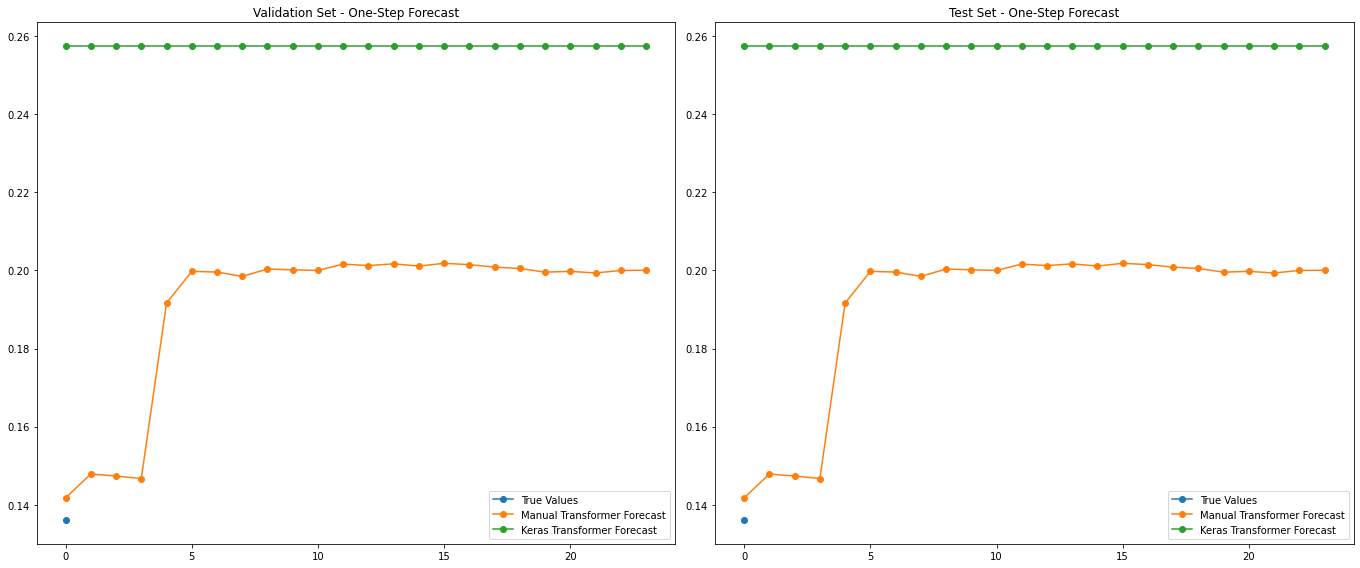

In [240]:
# Visualizing Forecasts for Validation and Test Set
plt.figure(figsize=(19, 8))

# Subplot for Validation Set
plt.subplot(1, 2, 1)
plt.plot(val_data_targets[-1], label='True Values', marker='o')
plt.plot(val_predictions_manul_flat[-1], label='Manual Transformer Forecast', marker='o')
plt.plot(val_predictions_keras_flat[-1], label='Keras Transformer Forecast', marker='o')
plt.title('Validation Set - One-Step Forecast')
plt.legend()

# Subplot for Test Set
plt.subplot(1, 2, 2)
plt.plot(test_data_targets[-1], label='True Values', marker='o')
plt.plot(test_predictions_manul_flat[-1], label='Manual Transformer Forecast', marker='o')
plt.plot(test_predictions_keras_flat[-1], label='Keras Transformer Forecast', marker='o')
plt.title('Test Set - One-Step Forecast')
plt.legend()

plt.tight_layout()
plt.show()

### Make a Prediction | One step Forecast

In [213]:
# Select the last sequence from the test data
input_sequence = test_data_inputs[-1].reshape((1, sequence_length, num_features))

# Make predictions using the manual model
manual_forecast = manul_model.predict(input_sequence)

# Make predictions using the keras model
keras_forecast = keras_model.predict(input_sequence)

# Reshape the forecasts if needed
manual_forecast = manual_forecast.reshape((1, -1))
keras_forecast = keras_forecast.reshape((1, -1))

# Evaluate the forecasts
forecast_target = test_data_targets[-1]  # Actual values for the next time step

# Calculate MAE and RMSE for manual model
manual_mae = np.mean(np.abs(forecast_target - manual_forecast))
manual_rmse = np.sqrt(np.mean(np.square(forecast_target - manual_forecast)))

# Calculate MAE and RMSE for keras model
keras_mae = np.mean(np.abs(forecast_target - keras_forecast))
keras_rmse = np.sqrt(np.mean(np.square(forecast_target - keras_forecast)))

print('\n\nOne-Step Forecast Evaluation:\n-------------------------------')
print('Manual Model:')
print(f'MAE: {manual_mae}')
print(f'RMSE: {manual_rmse}')

print('\nKeras Model:')
print(f'MAE: {keras_mae}')
print(f'RMSE: {keras_rmse}')

1/1 [==============================] - 0s 38ms/step


One-Step Forecast Evaluation:
-------------------------------
Manual Model:
MAE: 0.05488822638685647
RMSE: 0.05850515385499535

Keras Model:
MAE: 0.12139765078519922
RMSE: 0.12139765078519923
